<a href="https://colab.research.google.com/github/dkaratzas/DL2022-23/blob/main/Problems%207%20-%20Autoencoders/P7_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%207%20-%20Autoencoders/P7_Autoencoders.ipynb)

# Autoencoders

In this notebook we will explore three different types of autoencoder architectures: Simple MLP Autoencoder, Convolutional Autoencoder and Variational Autoencoder (VAE). We will also see how we can use VAEs to generate new data.

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

/Users/josepsmachine/miniforge3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setting up

In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.has_mps, "GPU is not enabled"

#  use gpu if available
device = torch.device("mps" if torch.has_mps else "cpu")

In [3]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

100%|██████████| 9912422/9912422 [00:00<00:00, 13159819.11it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45642687.95it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 12580226.39it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22465246.19it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Simple Autoencoder

We will define a simple MLP Autoencoder

In [14]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=70),
            nn.ReLU(),
            nn.Linear(in_features=70, out_features=5),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=5, out_features=70),
            nn.ReLU(),
            nn.Linear(in_features=70, out_features=input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x            

In [15]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [16]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader:
        batch_features = batch_features.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

epoch : 1/10, Train loss = 0.063205
epoch : 1/10, Test loss = 0.062655


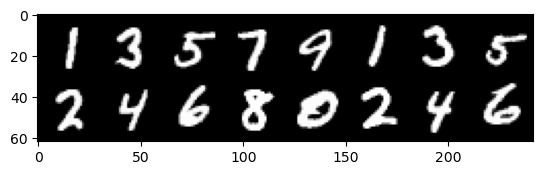

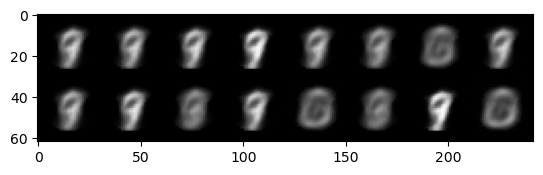

epoch : 2/10, Train loss = 0.061773
epoch : 2/10, Test loss = 0.060937


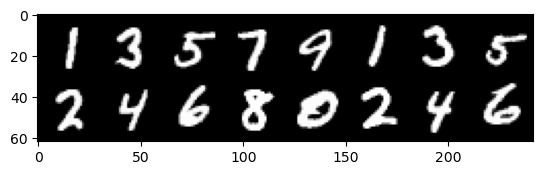

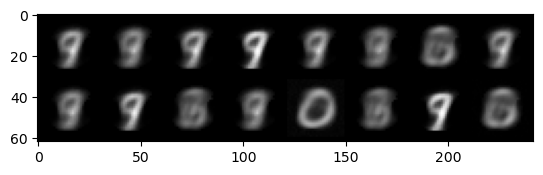

epoch : 3/10, Train loss = 0.053906
epoch : 3/10, Test loss = 0.044248


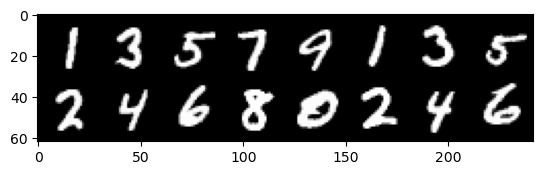

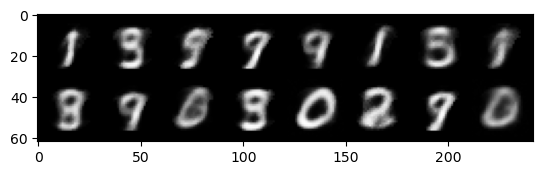

epoch : 4/10, Train loss = 0.041466
epoch : 4/10, Test loss = 0.039489


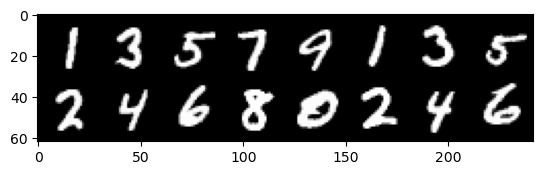

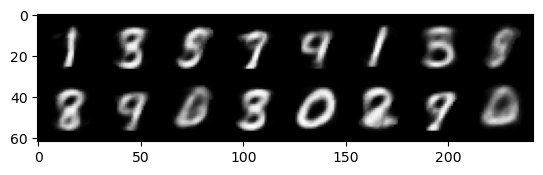

epoch : 5/10, Train loss = 0.038906
epoch : 5/10, Test loss = 0.038057


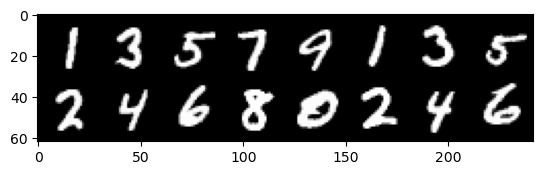

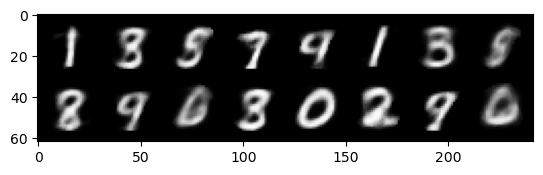

epoch : 6/10, Train loss = 0.037778
epoch : 6/10, Test loss = 0.037146


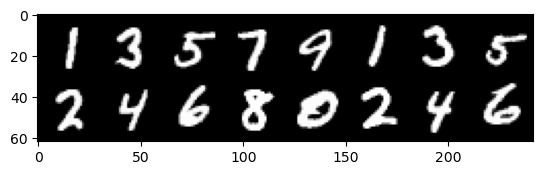

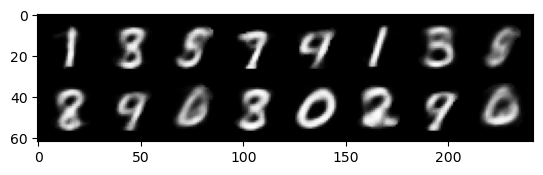

epoch : 7/10, Train loss = 0.037032
epoch : 7/10, Test loss = 0.036573


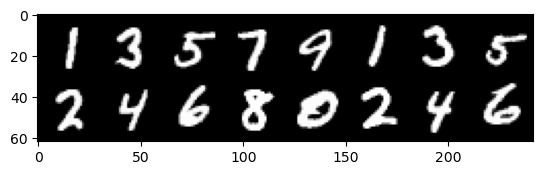

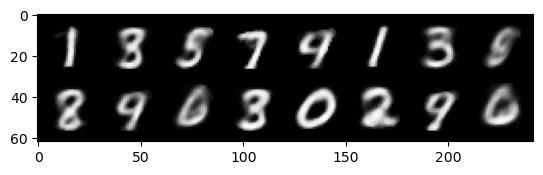

epoch : 8/10, Train loss = 0.036495
epoch : 8/10, Test loss = 0.036170


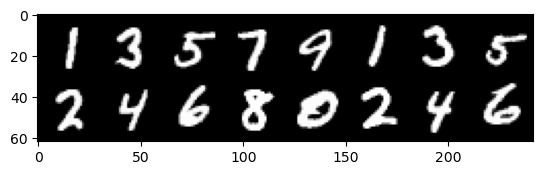

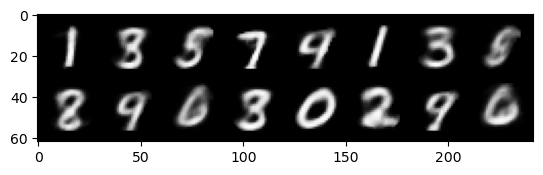

epoch : 9/10, Train loss = 0.036044
epoch : 9/10, Test loss = 0.035722


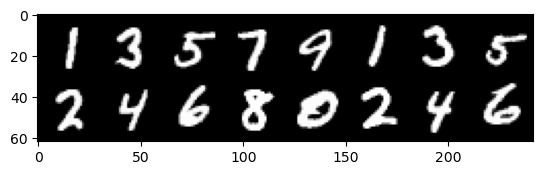

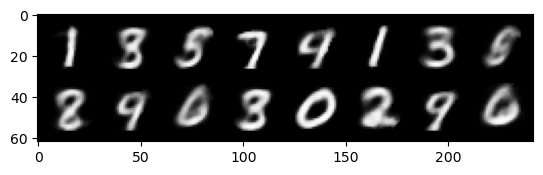

epoch : 10/10, Train loss = 0.035664
epoch : 10/10, Test loss = 0.035434


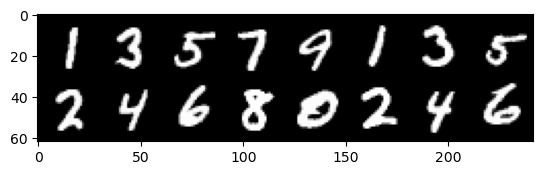

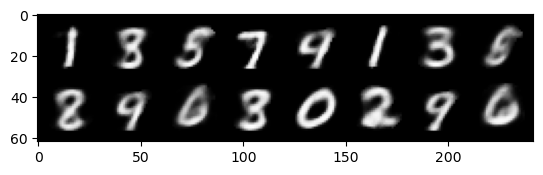

In [18]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True) 

# Convolutional Autoencoder

We will now build a convolutional Autoencoder. Below you can find an incomplete implementation of one (only the encoder part)...

In [34]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(), #necessary?
            nn.ConvTranspose2d(16, 16, 3, stride=3, padding=1),
            nn.ReLU(), #necessary?
            nn.ConvTranspose2d(16, 16, 5, stride=1, padding=0),
            nn.ReLU(), #necessary?
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=0),
            nn.ReLU(), #necessary?
            nn.ConvTranspose2d(8, 1, 6, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        
        return x

In [35]:
model = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [36]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True) 

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [128, 784]

<span style="color:blue">

**Exercise 1**: Build the decoder for the convolutional autoencoder model above and train it using the same functions and hyper-parameters as defined above.

> Hint: Use only deconvolutions (design an non-symmetric architecture) so that you do not have to store indices for the unpooling layers. Have a look at `ConvTranspose2d()` https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    
> Hint: Remember that to calculate the new activation map's size while deconvolving you should use: $𝑛^{[𝑙]} =(𝑛^{[𝑙−1]}−1) 𝑠 − 2𝑝 + 𝑓$
    
</span>

<span style="color:blue">

**Exercise 2 (HOMEWORK)**: Rebuild the network, but this time do a symmetric design for the decoder (using unpooling as required) and train it using the same functions and hyper-parameters as defined above.

> Hint: Have a look at `MaxUnpool2d()` https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html
    
</span>

In [ ]:
# Your Code Here


# Variational Autoencoders (VAEs)

Below we define a variational autoencoder. It takes a vector of 784 elements, and maps it into a mean and a `logvar` of size 20.

Note that `logvar` corresponds to $ln(\sigma^2)$.

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In the case of the VAE, we need to define our own loss function, as we need to combine the reconstruction loss, with the regularisation term (Gaussian prior for the embedding distribution).

> *NOTE: You will see that we use an MSE loss as a reconstruction loss, instead of the negative log likelihood that we should be using... this actually makes sense. We have designed this model so that the output of the decoder is the image - the pixel values (means) and not distributions over the pixel values (e.g. means and variances of a Gaussian).*

> *This is typical in VAE implementations; the output of the decoder is actually the mean $\mu_{x|z}$ (let's just call it $\mu$) and we usually assumes a unitary covariance. So in that case we have: $log(P(x|z))=-{\frac 1 2}[log(|Σ|)+k log(2\pi)+(x−\mu)^T(x−\mu)]$*

> *This comes from taking the log of the probability density function of a multivariate Gaussian distribution. Now you can see that since the first two terms are constant with respect to $\mu$, the optimization problem is equivalent to maximizing $-{\frac 1 2}(x−\mu)^T(x−\mu)$ which is the just the L2 loss between $x$ and $\mu$. Finally the expectation is just approximated by averaging.*

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    # Reconstruction term
    recLoss = nn.MSELoss(reduction='sum')

    # KL divergence regularisation term
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

In [ ]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()    
    
    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader:
        batch_features = batch_features.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

epoch : 1/10, Train loss = 5848.284478
epoch : 1/10, Test loss = 1180.568022
torch.Size([16, 784])


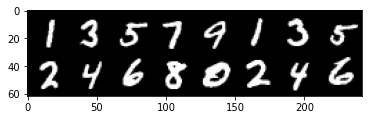

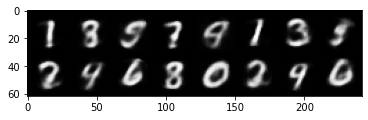

epoch : 2/10, Train loss = 4510.176254
epoch : 2/10, Test loss = 1072.774693
torch.Size([16, 784])


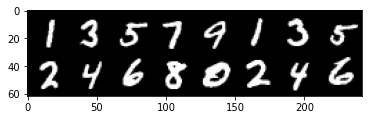

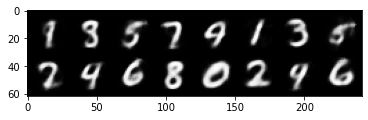

epoch : 3/10, Train loss = 4253.818063
epoch : 3/10, Test loss = 1034.292284
torch.Size([16, 784])


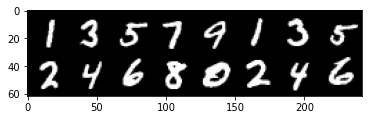

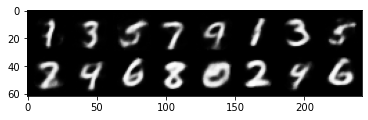

epoch : 4/10, Train loss = 4135.057329
epoch : 4/10, Test loss = 1013.949244
torch.Size([16, 784])


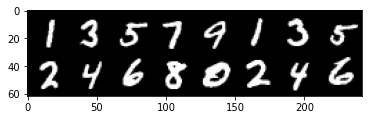

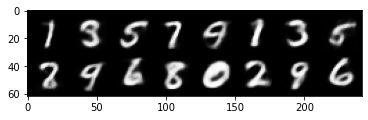

epoch : 5/10, Train loss = 4062.734053
epoch : 5/10, Test loss = 1000.834718
torch.Size([16, 784])


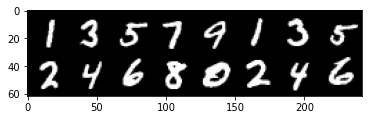

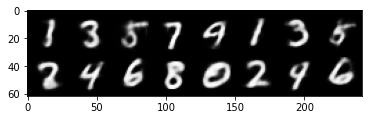

epoch : 6/10, Train loss = 4017.672188
epoch : 6/10, Test loss = 992.815178
torch.Size([16, 784])


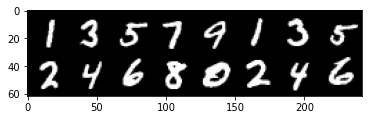

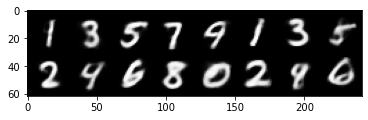

epoch : 7/10, Train loss = 3981.842396
epoch : 7/10, Test loss = 984.849272
torch.Size([16, 784])


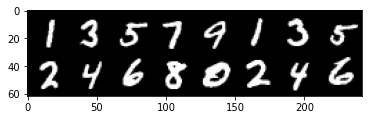

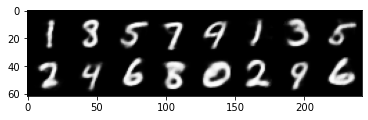

epoch : 8/10, Train loss = 3957.787147
epoch : 8/10, Test loss = 975.032224
torch.Size([16, 784])


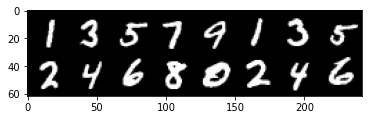

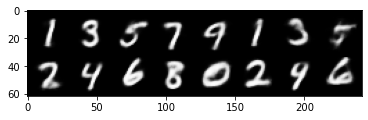

epoch : 9/10, Train loss = 3931.705656
epoch : 9/10, Test loss = 973.937293
torch.Size([16, 784])


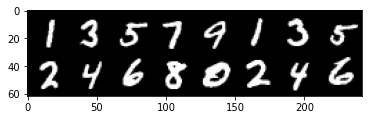

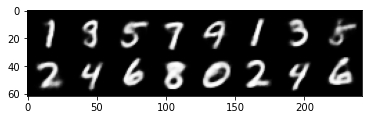

epoch : 10/10, Train loss = 3917.221139
epoch : 10/10, Test loss = 968.447588
torch.Size([16, 784])


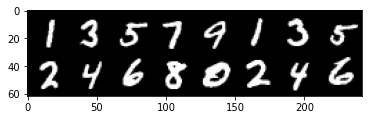

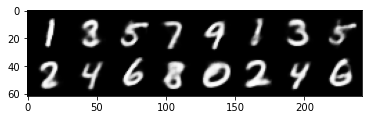

In [ ]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion) 

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them - you should be able to see an evolution from one to the other.

In [ ]:
model.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        #img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        #img2 = img2.view(img2.size(0), -1).to(device)
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):   
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits
    
    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])
    
        inter_image = inter_image.view(1, 28, 28)
        
        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show() 

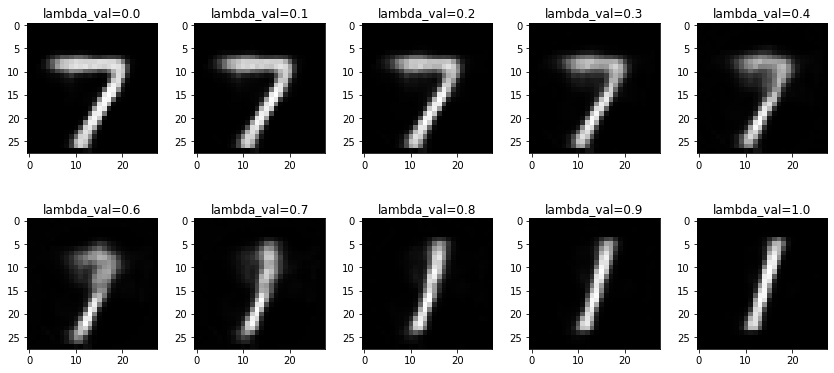

In [ ]:
visualize_interpolation(model, test_loader, 7, 1)

<span style="color:blue">

**Exercise 3**: Use the already trained VAE model to generate 100 random new digits.

> Hint: Have a look at PyTorch's `randn()` https://pytorch.org/docs/stable/generated/torch.randn.html
    
</span>

In [ ]:
# Your Code Here



<span style="color:blue">

**Exercise 4**: Modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and then complete the cell below to visualize the entire 2D latent space.
    
</span>

In [ ]:
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    # Your code here
   
   
    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.view(-1, 1, 28, 28),20,5))
    plt.show()

<span style="color:blue">

**Exercise 5**: Try both the simple encoder and the convolutional encoder with the FashionMNIST dataset, comment what you observe for both results.
    
</span>

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader_FMNIST = torch.utils.data.DataLoader(
    train_dataset_FMNIST, batch_size=128, shuffle=True, num_workers=2#, pin_memory=True
)

test_loader_FMNIST = torch.utils.data.DataLoader(
    test_dataset_FMNIST, batch_size=32, shuffle=False, num_workers=2
)